In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
data_dir = '/Users/kysgattu/Downloads/COVID-19_Radiography_Dataset2'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    # check the folders from main directory. If there are another files, ignore them
    if pathlib.Path(foldpath).suffix != '':
        continue

    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        #print(filelist)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            if os.path.isdir(fpath):
                # check if there are another folders
                if pathlib.Path(foldpath).suffix == '':
                    # check unneeded masks
                    if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or pathlib.Path(fpath).parts[-1] == 'MASKS':
                        continue

                    else:
                        o_file = os.listdir(fpath)
                        for f in o_file:
                            ipath = os.path.join(fpath, f)
                            filepaths.append(ipath)
                            labels.append(fold)

                else:
                    filepaths.append(fpath)
                    labels.append(fold)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

strat = df['labels']
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

print(f'Train size: {len(train_df)}, Validation size: {len(valid_df)}, Test size: {len(test_df)}')

Train size: 16932, Validation size: 2116, Test size: 2117


In [3]:
img_size = (224, 224)
channels = 3 # either BGR or Grayscale
color = 'rgb'
img_shape = (img_size[0], img_size[1], channels)
batch_size = 16

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= color, shuffle= False, batch_size= test_batch_size)

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [4]:
model = keras.models.load_model('/Users/kysgattu/Desktop/ChestXRayClassification/LeNet_Saved.h5')
#model = keras.models.load_model('test.h5')

Metal device set to: Apple M1 Pro


2023-04-18 11:31:14.552864: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-18 11:31:14.553037: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
model.evaluate(test_gen)

2023-04-18 11:31:17.101944: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-18 11:31:17.335459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 6s 146ms/step - loss: 0.6173 - accuracy: 0.7704


[0.6172623038291931, 0.7704298496246338]

In [6]:
preds = model.predict_generator(test_gen)

2023-04-18 11:31:28.993071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [7]:
y_pred = np.argmax(preds, axis=1)

In [8]:
y_pred

array([1, 2, 1, ..., 1, 1, 2])

In [9]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)


In [16]:
cr2 = classification_report(test_gen.classes, y_pred, target_names= classes)

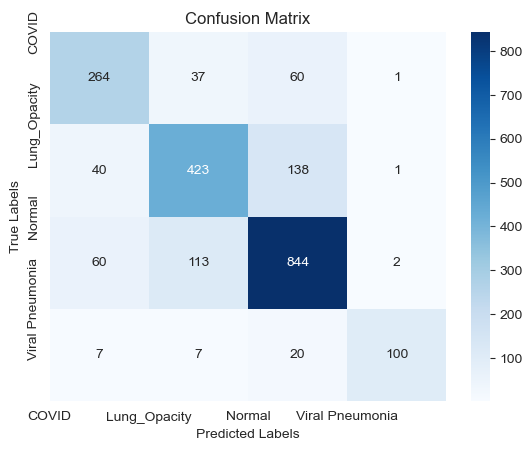

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_true and y_pred are the true and predicted labels, respectively


# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels, title, and ticks to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0, 1, 2, 3], labels=classes)
plt.yticks(ticks=[0, 1, 2, 3], labels=classes)
plt.show()


In [19]:
print(cr2)

                 precision    recall  f1-score   support

          COVID       0.71      0.73      0.72       362
   Lung_Opacity       0.73      0.70      0.72       602
         Normal       0.79      0.83      0.81      1019
Viral Pneumonia       0.96      0.75      0.84       134

       accuracy                           0.77      2117
      macro avg       0.80      0.75      0.77      2117
   weighted avg       0.77      0.77      0.77      2117



In [20]:
model = keras.models.load_model('/Users/kysgattu/Desktop/ChestXRayClassification/VGG.h5')
#model = keras.models.load_model('test.h5')

In [21]:
model.evaluate(test_gen)

2023-04-18 11:42:46.244192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 28s 916ms/step - loss: 0.2323 - accuracy: 0.9225


[0.23234760761260986, 0.9225319027900696]

In [22]:
preds = model.predict_generator(test_gen)

2023-04-18 11:43:16.898868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [23]:
y_pred = np.argmax(preds, axis=1)

In [24]:
y_pred

array([1, 1, 1, ..., 2, 2, 2])

In [25]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)


In [26]:
cr2 = classification_report(test_gen.classes, y_pred, target_names= classes)

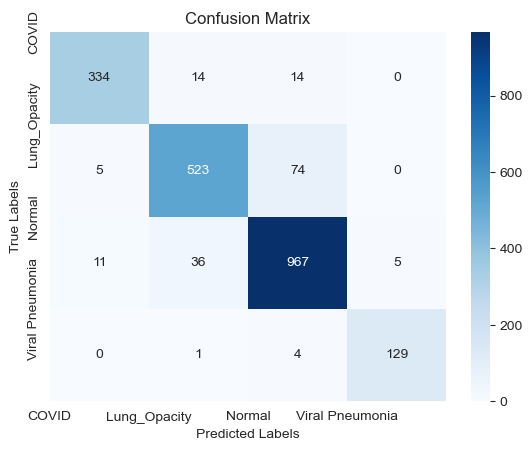

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# y_true and y_pred are the true and predicted labels, respectively


# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels, title, and ticks to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0, 1, 2, 3], labels=classes)
plt.yticks(ticks=[0, 1, 2, 3], labels=classes)
plt.show()


In [28]:
print(cr2)

                 precision    recall  f1-score   support

          COVID       0.95      0.92      0.94       362
   Lung_Opacity       0.91      0.87      0.89       602
         Normal       0.91      0.95      0.93      1019
Viral Pneumonia       0.96      0.96      0.96       134

       accuracy                           0.92      2117
      macro avg       0.94      0.93      0.93      2117
   weighted avg       0.92      0.92      0.92      2117

